<a href="https://colab.research.google.com/github/inschools-ng/MitsLinReg/blob/main/Copy_of_IE_595_Homework_2_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IE 595: HOMEWORK 4

In this exercise, we will predict the number of applications received using the other
variables in the “College” dataset.

(a) Split the data set into a training set and a test set.


(b) Fit a linear model using least squares on the training set, and report the test error
obtained.


(c) Fit a ridge regression model on the training set, with λ chosen by cross-validation.
Report the test error obtained.


(d) Fit a lasso model on the training set, with λ chosen by cross-validation. Report the test
error obtained, along with the number of non-zero coefficient estimates.


(e) Fit a PCR model on the training set, with M chosen by cross-validation. Report the test
error obtained, along with the value of M selected by cross-validation.


(f) Fit a PLS model on the training set, with M chosen by cross-validation. Report the test
error obtained, along with the value of M selected by cross-validation.


(g) Comment on the results obtained. How accurately can we predict the number of college
applications received? Is there much difference among the test errors resulting from these
five approaches?




In [1]:
!pip install ISLP


  Using cached numpy-1.24.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.4 which is incompatible.


In [2]:
!pip install l0bnb

  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
pygam 0.9.0 requires numpy<2.0.0,>=1.24.2, but you have numpy 1.23.5 which is incompatible.


In [55]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
import sklearn.linear_model as skl
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn.svm as SVR
import pandas as pd
import numpy as np

from matplotlib.pyplot import subplots
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import  PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      summarize,
      poly,
      ModelSpec as MS,
      sklearn_selection_path)
from l0bnb import fit_path

from sklearn.preprocessing import StandardScaler,RobustScaler
from statsmodels.api import OLS
from scipy.stats import boxcox_normmax, zscore
from multiprocessing import cpu_count
from lightgbm import LGBMRegressor
from scipy.special import boxcox1p

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,auc,accuracy_score,precision_recall_curve,roc_curve,mean_squared_error,make_scorer
from sklearn.model_selection import cross_val_score, KFold
from mlxtend.regressor import StackingCVRegressor

from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
import scipy.stats as stats

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/College.csv')
df.info()
df.columns

In [9]:
## Label rows by college
df = df.set_index(['Unnamed: 0'], append=True, verify_integrity=True)
df.rename_axis([None, 'College'], inplace=True)
df.head()

,,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
,College,,,,,,,,,,,,,,,,,,
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 777 entries, (0, 'Abilene Christian University') to (776, 'York College of Pennsylvania')
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Private      777 non-null    object 
 1   Apps         777 non-null    int64  
 2   Accept       777 non-null    int64  
 3   Enroll       777 non-null    int64  
 4   Top10perc    777 non-null    int64  
 5   Top25perc    777 non-null    int64  
 6   F.Undergrad  777 non-null    int64  
 7   P.Undergrad  777 non-null    int64  
 8   Outstate     777 non-null    int64  
 9   Room.Board   777 non-null    int64  
 10  Books        777 non-null    int64  
 11  Personal     777 non-null    int64  
 12  PhD          777 non-null    int64  
 13  Terminal     777 non-null    int64  
 14  S.F.Ratio    777 non-null    float64
 15  perc.alumni  777 non-null    int64  
 16  Expend       777 non-null    int64  
 17  Grad.Rate    777 non-nul

In [11]:
df.columns

Index(['Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Books',
       'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend',
       'Grad.Rate'],
      dtype='object')

In [12]:
df.describe()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.00000
mean,3001.638353,2018.804376,779.972973,27.558559,55.796654,3699.907336,855.298584,10440.669241,4357.526384,549.380952,1340.642214,72.660232,79.702703,14.089704,22.743887,9660.171171,65.46332
std,3870.201484,2451.113971,929.176190,17.640364,19.804778,4850.420531,1522.431887,4023.016484,1096.696416,165.105360,677.071454,16.328155,14.722359,3.958349,12.391801,5221.768440,17.17771
min,81.000000,72.000000,35.000000,1.000000,9.000000,139.000000,1.000000,2340.000000,1780.000000,96.000000,250.000000,8.000000,24.000000,2.500000,0.000000,3186.000000,10.00000
25%,776.000000,604.000000,242.000000,15.000000,41.000000,992.000000,95.000000,7320.000000,3597.000000,470.000000,850.000000,62.000000,71.000000,11.500000,13.000000,6751.000000,53.00000
50%,1558.000000,1110.000000,434.000000,23.000000,54.000000,1707.000000,353.000000,9990.000000,4200.000000,500.000000,1200.000000,75.000000,82.000000,13.600000,21.000000,8377.000000,65.00000
75%,3624.000000,2424.000000,902.000000,35.000000,69.000000,4005.000000,967.000000,12925.000000,5050.000000,600.000000,1700.000000,85.000000,92.000000,16.500000,31.000000,10830.000000,78.00000
max,48094.000000,26330.000000,6392.000000,96.000000,100.000000,31643.000000,21836.000000,21700.000000,8124.000000,2340.000000,6800.000000,103.000000,100.000000,39.800000,64.000000,56233.000000,118.00000


In [13]:
# define categorical dummies
df = pd.get_dummies(df)

In [14]:
df.head()

,,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private_No,Private_Yes
,College,,,,,,,,,,,,,,,,,,,
0,Abilene Christian University,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,0,1
1,Adelphi University,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,0,1
2,Adrian College,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,0,1
3,Agnes Scott College,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,0,1
4,Alaska Pacific University,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,0,1


<ipython-input-15-f4a4e6cbd9fc>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sn.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sn.diverging_palette(220,10,as_cmap=True),


<Axes: >

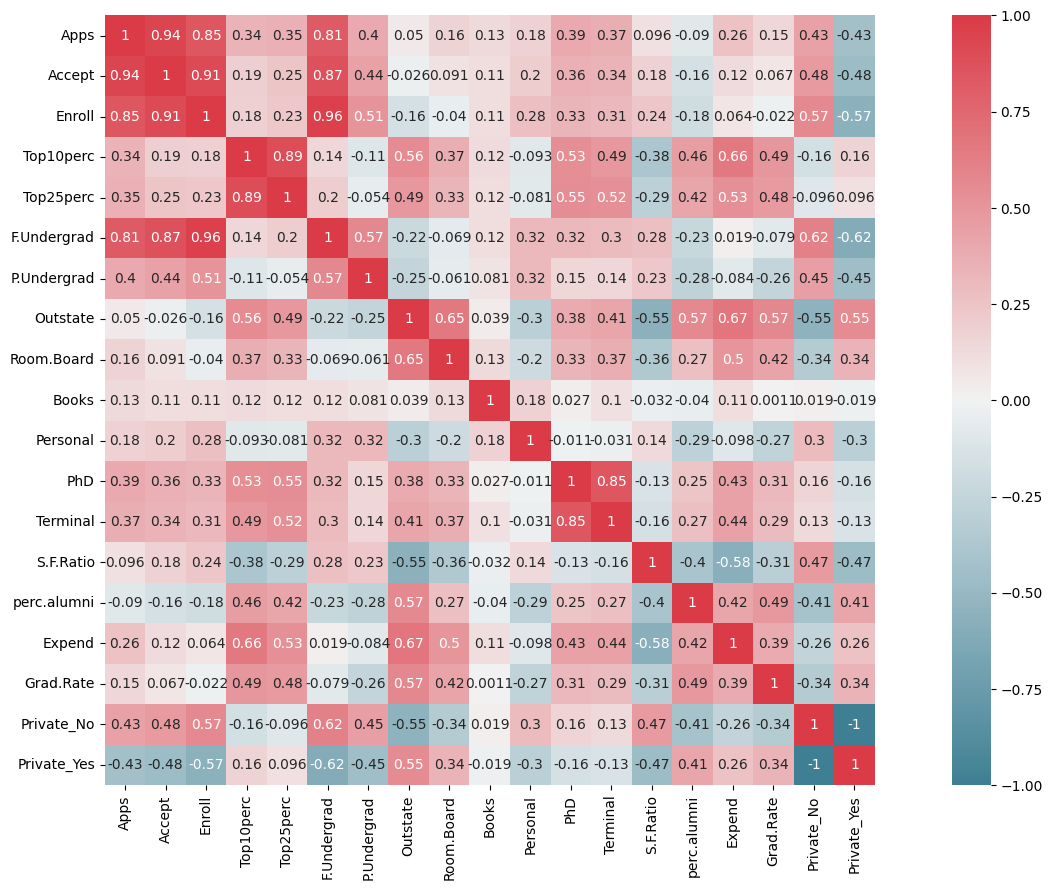

<Figure size 2000x1000 with 0 Axes>

In [15]:
# Correlation matrix

f,ax = plt.subplots(figsize=(20,10))
corr = df.corr()
plt.figure(figsize=(20,10))
sn.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sn.diverging_palette(220,10,as_cmap=True),
          square=True,ax=ax,annot=True)


In the above correlation matrix, Private_yes which is a dummy variable of the "Yes" value show little to no correlation with any other feature in the dataset.
From question 1c and above - Ridge regression, Lasso regression and PCR we need to perform standardization as advised by the text. There is a conflict in standardizing categorical variables. However due to the problem not being a classification problem, the dummy feature would be dropped.  

In [16]:
df = df.astype(np.float64)
df = df.rename(index=str, columns={"F.Undergrad": "F_Undergrad",
                                   "P.Undergrad": "P_Undergrad",
                                   "S.F.Ratio": "S_F_Ratio",
                                   "perc.alumni": "perc_alumni",
                                   "Grad.Rate": "Grad_Rate",
                                   "Room.Board": "Room_Board"})

In [17]:
sns.pairplot(df,diag_kind="kde")

NameError: ignored

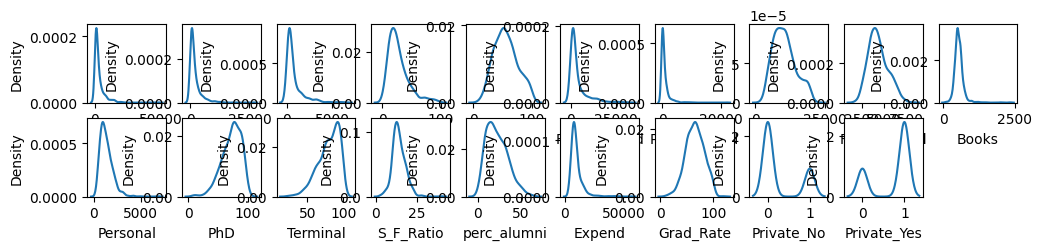

In [18]:
# data pre-processing
# checking for normal distributions

plt.figure(figsize=(12,12))
i=1
for col in df.columns:
  plt.subplot(10,10,i)
  sn.kdeplot(df[col])
  i+=1

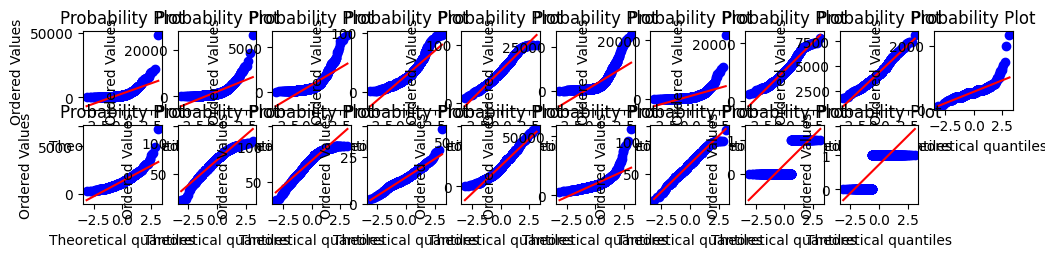

In [19]:
plt.figure(figsize=(12,12))
i=1
for col in df.columns:
  plt.subplot(10,10,i)
  stats.probplot(df[col], dist='norm', plot=plt)
  i+=1

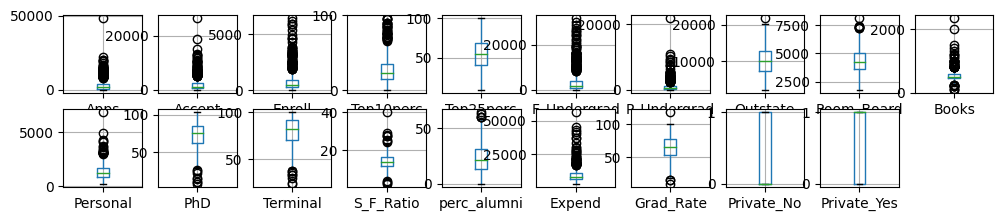

In [37]:
#detecting and handling outliers
plt.figure(figsize=(12,12))
i=1
for col in df.columns:
    plt.subplot(10,10,i)
    df[[col]].boxplot()
    i+=1

In [20]:
# check for skew
df.skew()

Apps           3.723750
Accept         3.417727
Enroll         2.690465
Top10perc      1.413217
Top25perc      0.259340
F_Undergrad    2.610458
P_Undergrad    5.692353
Outstate       0.509278
Room_Board     0.477356
Books          3.485025
Personal       1.742497
PhD           -0.768170
Terminal      -0.816542
S_F_Ratio      0.667435
perc_alumni    0.606891
Expend         3.459322
Grad_Rate     -0.113777
Private_No     1.021933
Private_Yes   -1.021933
dtype: float64

In [21]:
# Z-score method of outlier handling
for col in df.iloc[:,:-1]:
  if df[col].skew()<0.5 and df[col].skew()>-0.5:
    up_limit = df[col].mean() + 3 *df[col].std()
    lw_limit = df[col].mean() - 3 * df[col].std()

    df[col] = np.where(df[col]>up_limit, up_limit, np.where(df[col]<lw_limit, lw_limit, df[col]))
  elif df[col].skew()>0.5 or df[col].skew()<-0.5:
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    IQR = q3 - q1
    up_limit = q3 + 1.5 * IQR
    lw_limit = q1 - 1.5 * IQR

    df[col] = np.where(df[col]>up_limit, up_limit, np.where(df[col]<lw_limit, lw_limit, df[col]))


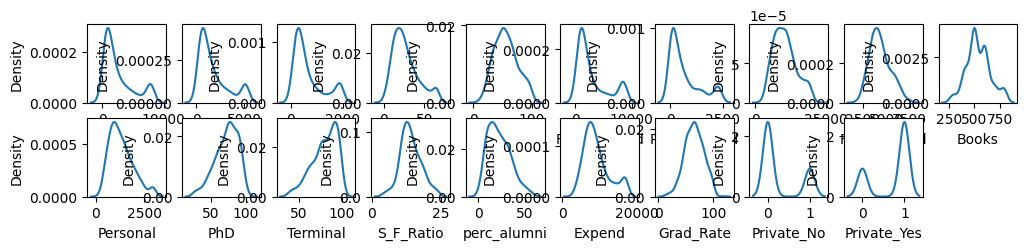

In [22]:
plt.figure(figsize=(12,12))
i=1
for col in df.columns:
  plt.subplot(10,10,i)
  sn.kdeplot(df[col])
  i+=1

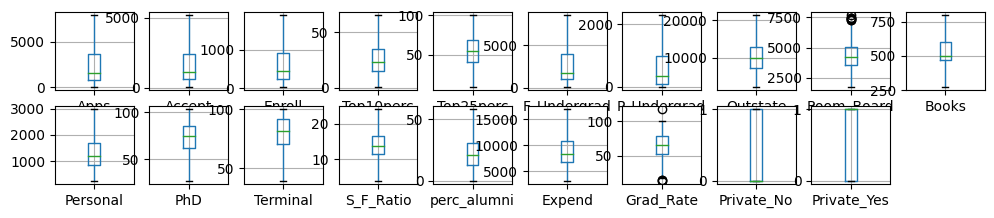

In [23]:
plt.figure(figsize=(12,12))
i=1
for col in df.columns:
  plt.subplot(10,10,i)
  df[[col]].boxplot()
  i+=1

#1.A and 1.B


In [24]:
## Train-Test Split
X = df.iloc[:,1:]
X = X.iloc[:,:]
X.head()

,,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Room_Board,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate,Private_No,Private_Yes
,College,,,,,,,,,,,,,,,,,,
0,Abilene Christian University,1232.0,721.0,23.0,52.0,2885.0,537.0,7440.0,3300.0,450.0,2200.0,70.0,78.0,18.1,12.0,7041.0,60.0,0.0,1.0
1,Adelphi University,1924.0,512.0,16.0,29.0,2683.0,1227.0,12280.0,6450.0,750.0,1500.0,29.0,39.5,12.2,16.0,10527.0,56.0,0.0,1.0
2,Adrian College,1097.0,336.0,22.0,50.0,1036.0,99.0,11250.0,3750.0,400.0,1165.0,53.0,66.0,12.9,30.0,8735.0,54.0,0.0,1.0
3,Agnes Scott College,349.0,137.0,60.0,89.0,510.0,63.0,12960.0,5450.0,450.0,875.0,92.0,97.0,7.7,37.0,16948.5,59.0,0.0,1.0
4,Alaska Pacific University,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,4120.0,795.0,1500.0,76.0,72.0,11.9,2.0,10922.0,15.0,0.0,1.0


In [25]:
print()
print()
y = df['Apps']
y.head()

   College                     
0  Abilene Christian University    1660.0
1  Adelphi University              2186.0
2  Adrian College                  1428.0
3  Agnes Scott College              417.0
4  Alaska Pacific University        193.0
Name: Apps, dtype: float64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=999)

In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)

model_ols = sm.OLS(y_train, X_train)
results = model_ols.fit()
print(summarize(results))

                  coef  std err       t  P>|t|
Accept          1.3155    0.056  23.534  0.000
Enroll         -0.1735    0.230  -0.754  0.451
Top10perc      11.0301    4.777   2.309  0.021
Top25perc       4.2512    3.481   1.221  0.222
F_Undergrad     0.1011    0.044   2.307  0.021
P_Undergrad    -0.0969    0.059  -1.633  0.103
Outstate        0.0127    0.015   0.851  0.395
Room_Board      0.1337    0.036   3.706  0.000
Books           0.4612    0.254   1.817  0.070
Personal        0.0285    0.052   0.543  0.587
PhD             0.4554    3.788   0.120  0.904
Terminal       -9.4939    3.989  -2.380  0.018
S_F_Ratio       2.1621   10.876   0.199  0.842
perc_alumni    -0.9617    2.981  -0.323  0.747
Expend          0.0301    0.017   1.781  0.075
Grad_Rate       6.1193    2.197   2.785  0.006
Private_No   -923.6751  327.425  -2.821  0.005
Private_Yes -1475.2447  310.786  -4.747  0.000


In [28]:
y_hat = lr.predict(X_test)
print("MSE:", np.mean((y_test - y_hat)**2))
print()
print(lr.score(X_test, y_test))

MSE: 391237.97333865555

0.9382772066087715


#1.C

##Cross-validated ridge test error



In [134]:
df = df.dropna()
df.shape

(777, 19)

In [135]:
design = MS(df.columns.drop('Apps')).fit(df)
Y = np.array(df['Apps'])
X = design.transform(df)
D = design.fit_transform(df)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [136]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2) / Y.std()
soln_Array = skl.ElasticNet.path(Xs, Y, l1_ratio=0., alphas=lambdas)[1]
print("\n\n",soln_Array.shape)
print("\n\n")



 (18, 50)





/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4844886777.020753, tolerance: 969022.6119
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not co

In [137]:
soln_Path = pd.DataFrame(soln_Array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_Path.index.name = 'negative log(lambda)'
print('\n\n\n', soln_Path)
print('\n\n')





                            Accept      Enroll   Top10perc   Top25perc  \
negative log(lambda)                                                    
-10.628895               0.055970    0.052547    0.018827    0.021355   
-10.158980               0.089539    0.084062    0.030118    0.034162   
-9.689064                0.143235    0.134472    0.048179    0.054648   
-9.219149                0.229118    0.215098    0.077066    0.087412   
-8.749234                0.366463    0.344031    0.123258    0.139804   
-8.279318                0.586047    0.550154    0.197104    0.223558   
-7.809403                0.936974    0.879539    0.315103    0.357383   
-7.339488                1.497448    1.405530    0.503520    0.571050   
-6.869573                2.391678    2.244546    0.804029    0.911785   
-6.399657                3.816091    3.580508    1.282429    1.454103   
-5.929742                6.079170    5.701781    2.041785    2.314612   
-5.459827                9.660025    9.055034  

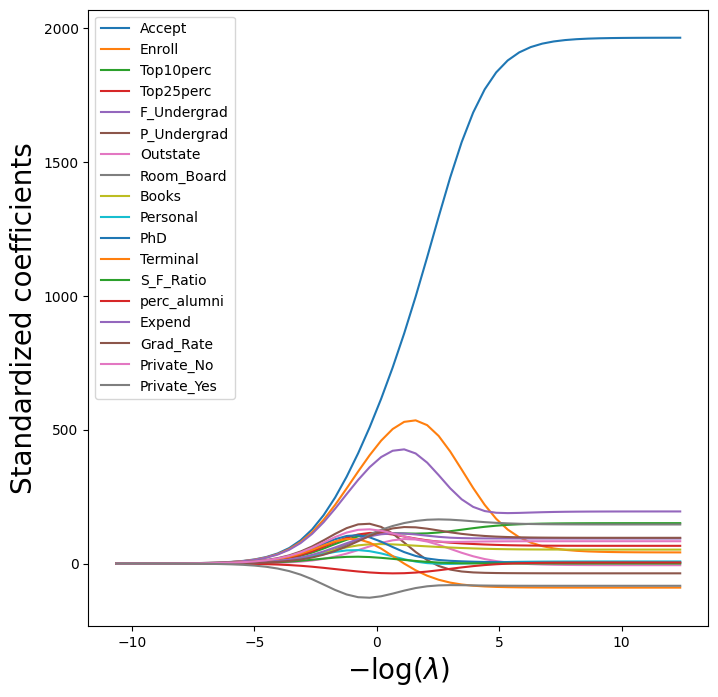

In [138]:
path_fig, ax = subplots(figsize=(8,8))
soln_Path.plot(ax=ax,legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

In [141]:
## Evaluating Test Error of Cross-Validated Ridge

outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=999)

scaler = StandardScaler(with_mean=True, with_std=True)


inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=999)


ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)

pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])


results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')


print('\n\n\n')
print(-results['test_score'].mean())
print('\n\n\n')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1325511806.5907793, tolerance: 265129.097472258
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did 





390146.099014475






/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100087677.81977126, tolerance: 272145.7304120172
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did

#1.D

##Cross-validated Lasso test error



In [44]:
LassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)

pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', LassoCV)])

pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

12.34084869053284

In [45]:
lambdas, soln_array = skl.Lasso.path(Xs,
                                     Y,
                                     l1_ratio=1,
                                     n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

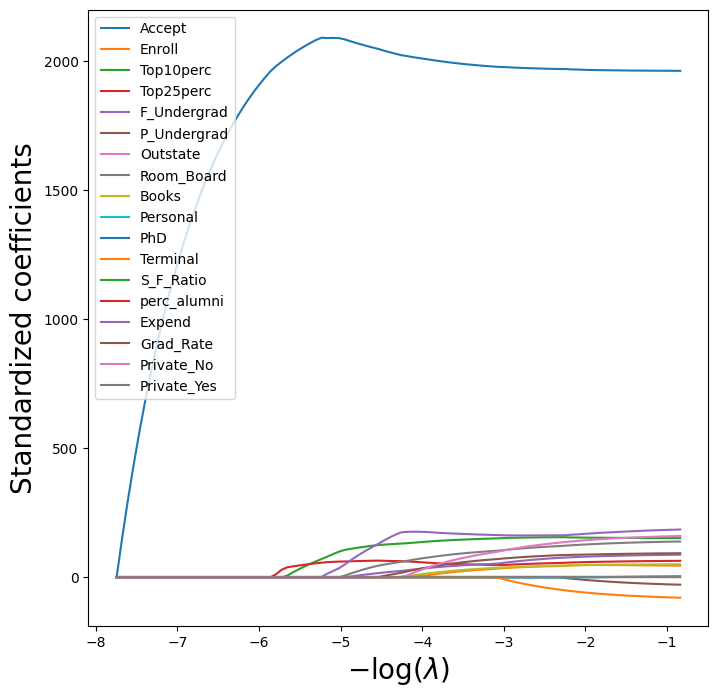

In [46]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20);


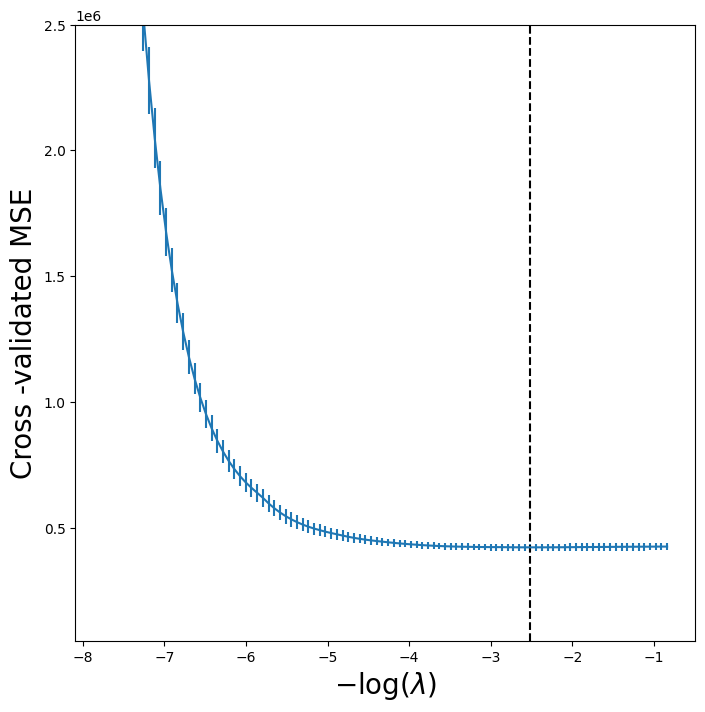

In [49]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
tuned_lasso.mse_path_.mean(1),
yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([50000,2500000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20);

In [50]:
tuned_lasso.coef_

array([ 1.96905980e+03,  4.61792369e+01,  1.54036853e+02,  5.51035580e+01,
        1.61814148e+02, -0.00000000e+00,  0.00000000e+00,  1.18272217e+02,
        4.45086231e+01,  0.00000000e+00, -0.00000000e+00, -3.86521499e+01,
       -0.00000000e+00,  0.00000000e+00,  7.19703732e+01,  8.35439071e+01,
        1.28055116e+02, -1.25011627e-12])

In [143]:
## Evaluating Test Error of Cross-Validated Lasso

outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=999)

scaler = StandardScaler(with_mean=True, with_std=True)

inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=999)

LassoCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=1,
                           cv=inner_cv)

pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', LassoCV)])

results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')

print('\n\n\n')
print(-results['test_score'])
print('\n\n\n')






[369563.76557529]






#1.E

##Cross-validated PCR test error

pca = PCA()
param_grid = {'pca__n_components': range(1,19)}

outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=999)

scaler = StandardScaler(with_mean=True, with_std=True)

inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=999)

linreg = skl.LinearRegression()

pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])

grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=inner_cv,
                        scoring='neg_mean_squared_error')

grid.fit(X,Y)







In [104]:
pca = PCA()
param_grid = {'pca__n_components': range(1,19)}

outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=999)

scaler = StandardScaler(with_mean=True, with_std=True)

inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=999)

linreg = skl.LinearRegression()

pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])

grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=inner_cv,
                        scoring='neg_mean_squared_error')

grid.fit(X,Y)



GridSearchCV(cv=KFold(n_splits=5, random_state=999, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 19)},
             scoring='neg_mean_squared_error')

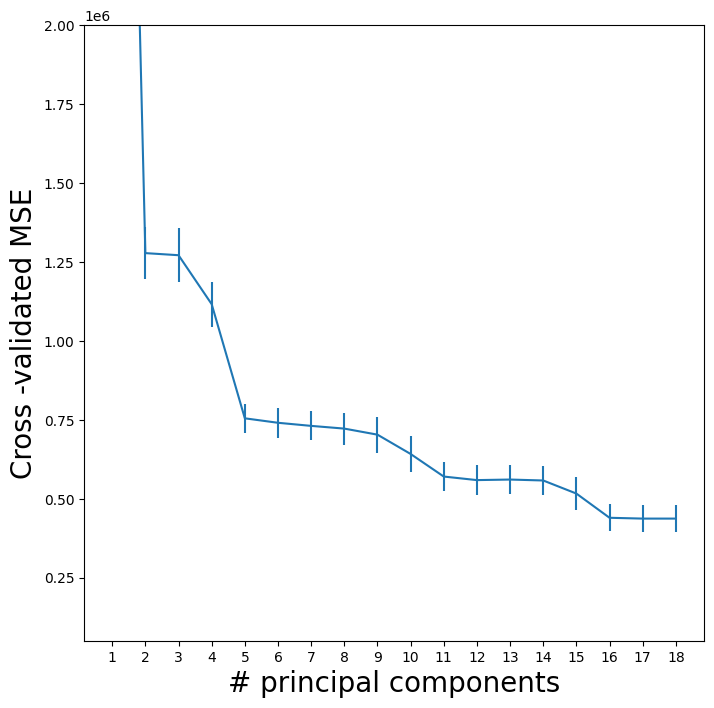

In [78]:
pcr_fig , ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp ,
-grid.cv_results_['mean_test_score'],
grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::])
ax.set_ylim([50000,2000000]);

In [107]:
#Xn = np.zeros((X.shape[0], 1))
cv_score = skm.cross_validate(linreg,
                             X,
                             Y,
                             cv=inner_cv,
                             scoring='neg_mean_squared_error')
-cv_score['test_score'].mean()

436606.2088686686

#1.F

##Cross-validated PLS test error

In [98]:
pls = PLSRegression(scale=True)
pls.fit(X,Y)

PLSRegression()

In [99]:
param_grid = {'n_components':range(1, 19)}
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv=inner_cv,
                        scoring='neg_mean_squared_error')
grid.fit(X,Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=999, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 19)},
             scoring='neg_mean_squared_error')

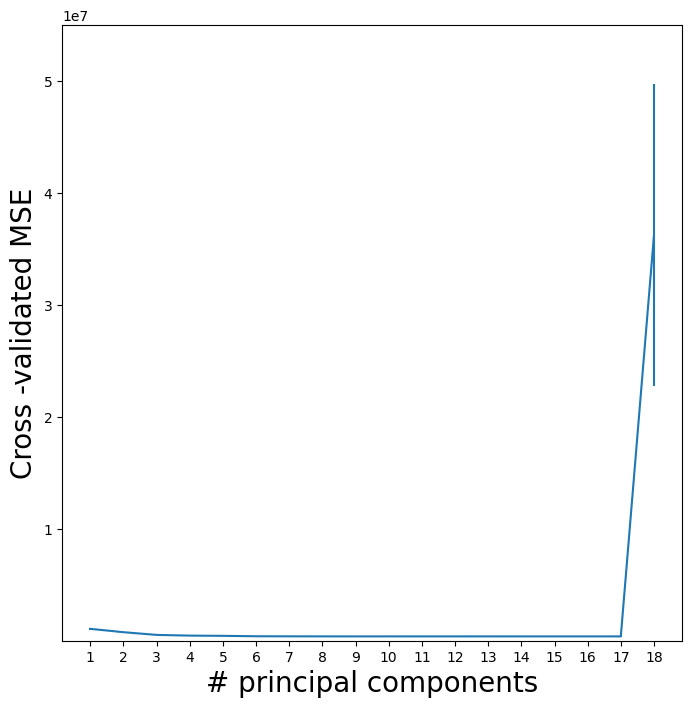

In [100]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp ,
-grid.cv_results_['mean_test_score'],
grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::])
ax.set_ylim([50000,55000000]);

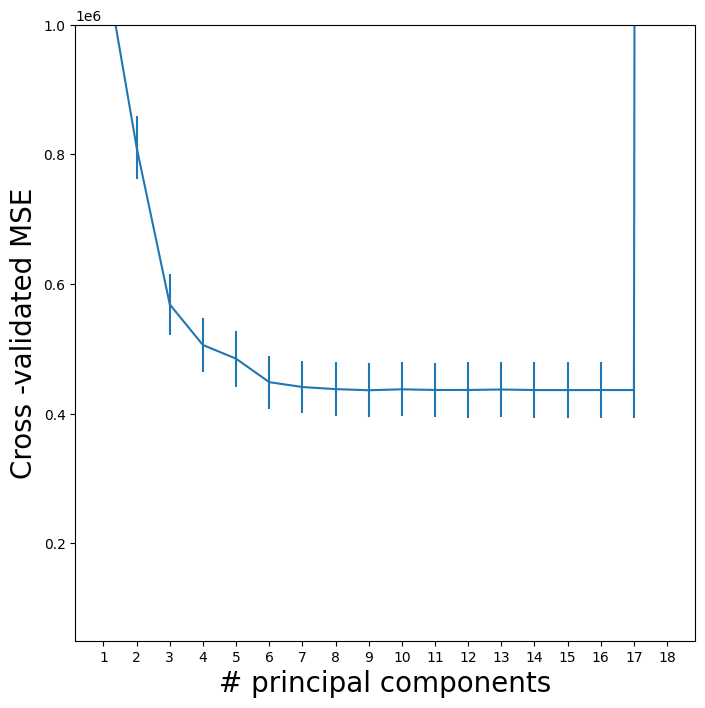

In [101]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp ,
-grid.cv_results_['mean_test_score'],
grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::])
ax.set_ylim([50000,1000000]);

In [142]:
#Xn = np.zeros((X.shape[0], 1))
cv_score = skm.cross_validate(pls,
                             X,
                             Y,
                             cv=inner_cv,
                             scoring='neg_mean_squared_error')
-cv_score['test_score'].mean()

810953.124891639

#1.G

##(g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?

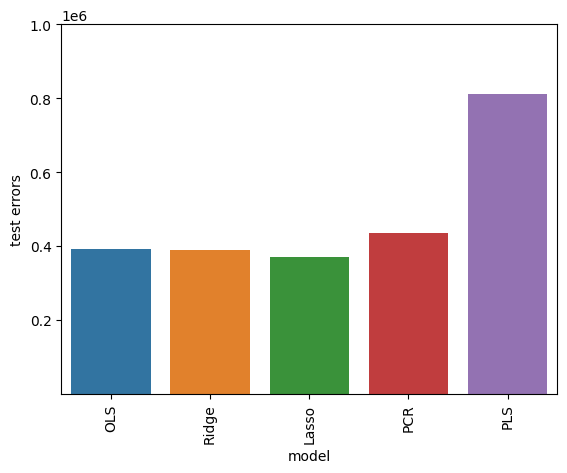

   model    test errors
0    OLS  391237.973339
1  Ridge  390146.099014
2  Lasso  370594.774712
3    PCR  436606.208869
4    PLS  810953.124892


In [13]:
models = ['OLS', 'Ridge', 'Lasso', 'PCR', 'PLS']
test_errors  = [391237.97333865555, 390146.09901448,
          370594.77471187, 436606.2088686686, 810953.124891639]
results = pd.DataFrame({'model': models, 'test errors': test_errors})

ax = sn.barplot(x='model', y='test errors', data=results)
ax.set_ylim([10,1000000])
plt.xticks(rotation=90)
plt.show();

print(results)


###We have seen that ridge regression with a wise choice of lambda has outperformed the least squares method. The difference may yet be insignificant in this dataset between Ridge and OLS method.

### The lasso performs better than the ridge for this test data in two ways. One is that the resulting coeffiicient estimates are sparse and secondly, the test error is lower than the ridge regression test error.

### Between ridge, lasso and OLS, the differnce may yet be very little.

### PCR and PLS give errors higher than the previous three models with PLS giving the most error of the five models.

### Lasso, Ridge and OLS with lower test erros indicate better model performance. Since Lasso has th lowest test error, it provides the most accurate predictions for number of college applications among the five methods.

### Using the correlation matrix and p-value summary, we can observe visually the features of the dataset with the most correlation to number of applications.

### While accuracy is crucial, the lasso model is relatively more interpretable than the ridge and OLS, it is also more interpretable than the PCR and PCS models because the features have been reduced to components which makes it harder to interpret esecially in college admissions where stakeholders would wnt to understand factors affecting college applications.

###The Lasso model dropped 6 of the 19 features, indicating no usefulness to these features in determining college applications.

###Another important issue to note is that to improve the prediction we have to incorporate the use of non-linear models as these models would account for the non-linear relationships not accounted for in these linear models.



#2. Apply various feature selection techniques including best subset selection, Lasso, PCA, and PLS to the “House Prices” dataset, which contains over 80 input features, to identify the most influential factors affecting house prices and develop an optimal predictive model for house price estimation.

In [61]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv', index_col=0)
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv', index_col=0)

In [66]:
df_train.info()
df_train.columns
df_train.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

(1460, 80)

In [63]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [64]:
df_train.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [67]:
df_train.shape

(1460, 80)

In [68]:
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


<ipython-input-71-f11e9bf3d623>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_train.corr()
<ipython-input-71-f11e9bf3d623>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sn.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sn.diverging_palette(220,10,as_cmap=True),


<Axes: >

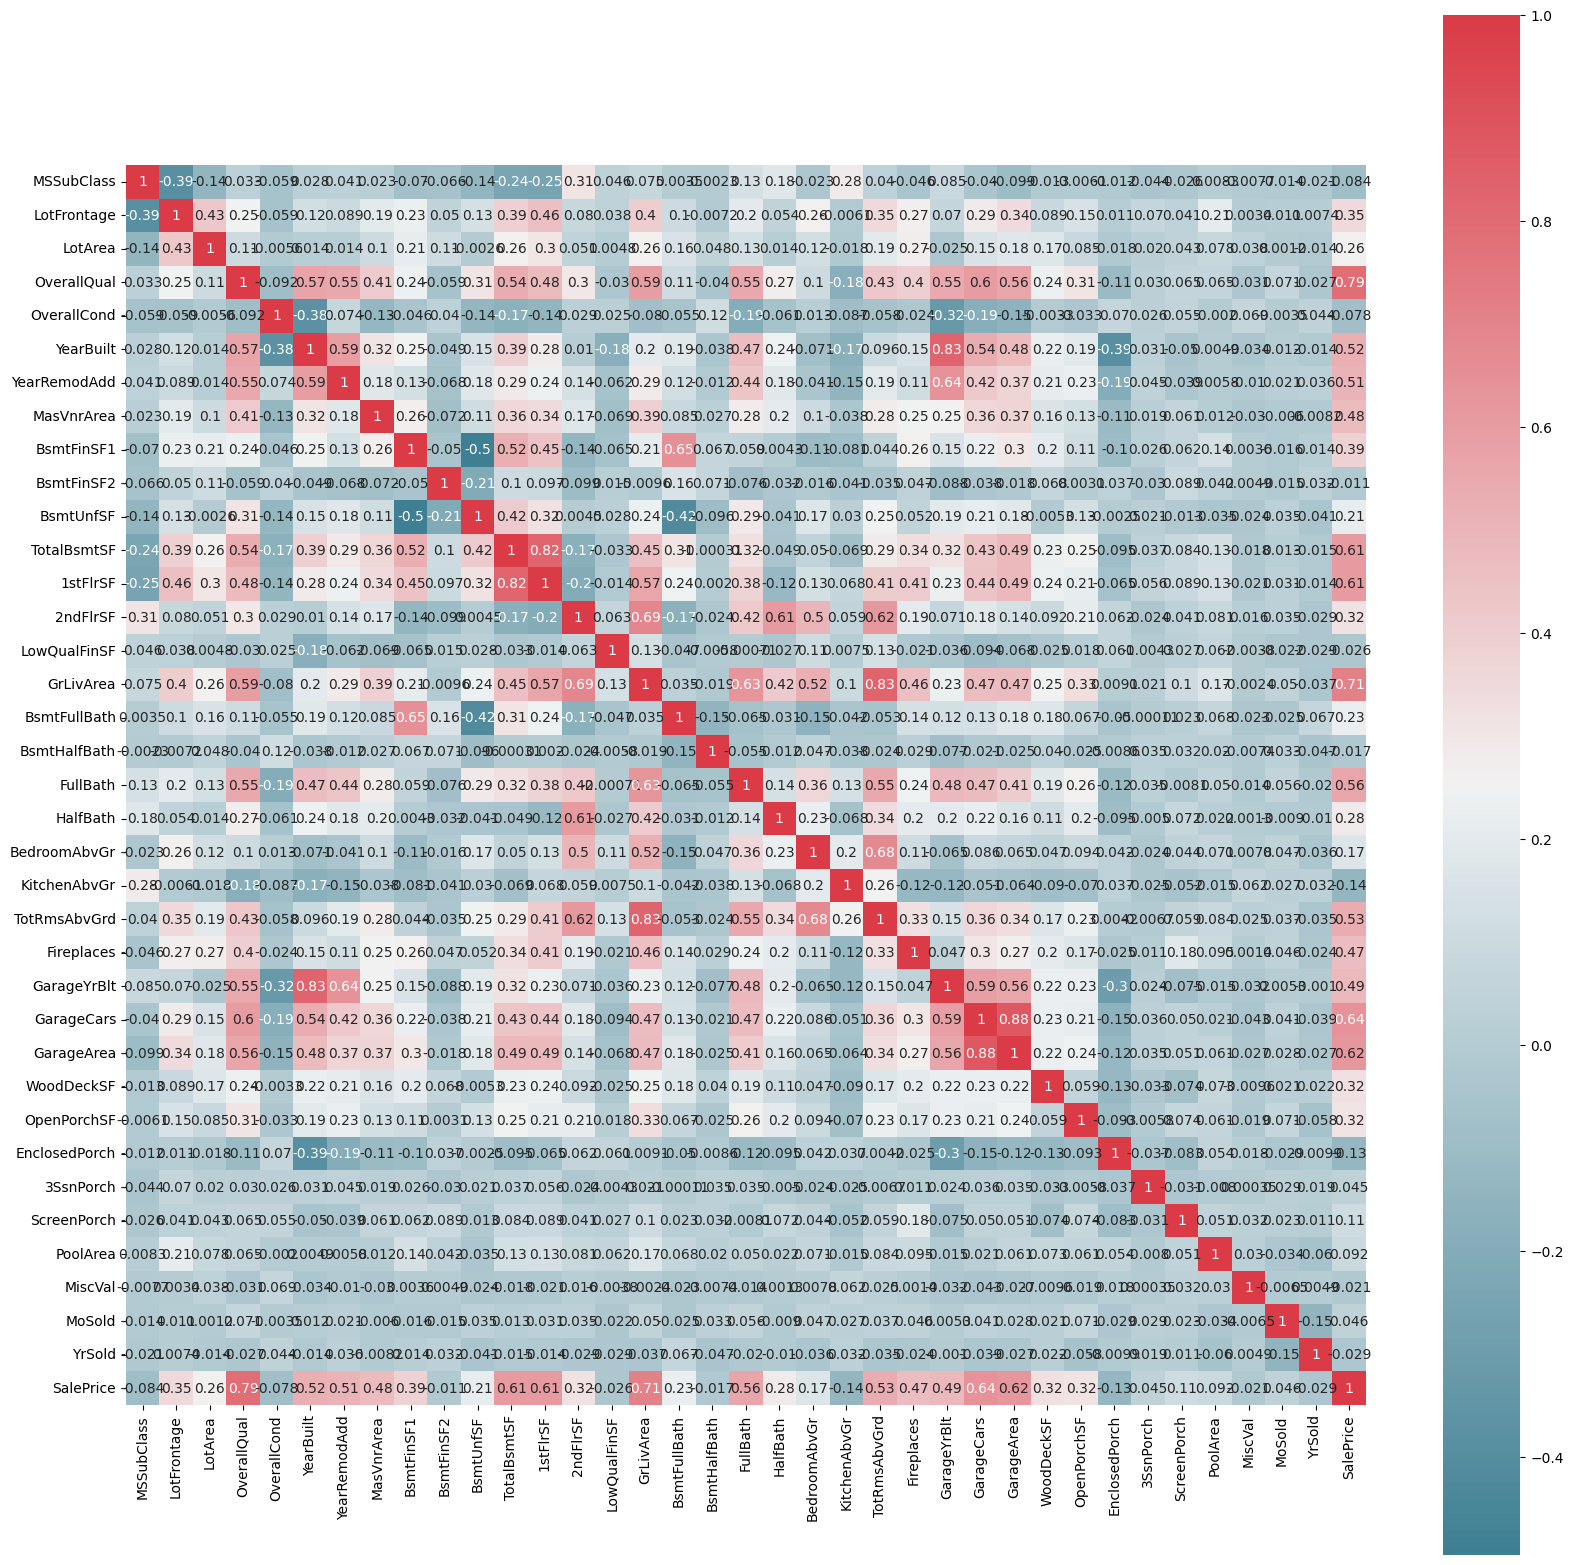

<Figure size 50000x10000 with 0 Axes>

In [71]:
# Correlation matrix
f,ax = plt.subplots(figsize=(20,20))
corr = df_train.corr()
plt.figure(figsize=(500,100))
sn.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sn.diverging_palette(220,10,as_cmap=True),
          square=True,ax=ax,annot=True)

In [84]:
# we firstly detect outliers and transform to fit the outliers.
# we concatenate the features so that we dont perform feature engineering twice.
# we split into features and target and transform the target to take care of the skew

df_train = df_train[df_train["GrLivArea"] < 4500]
X = pd.concat([df_train.drop("SalePrice", axis=1), df_test])
y_train = np.log(df_train["SalePrice"])

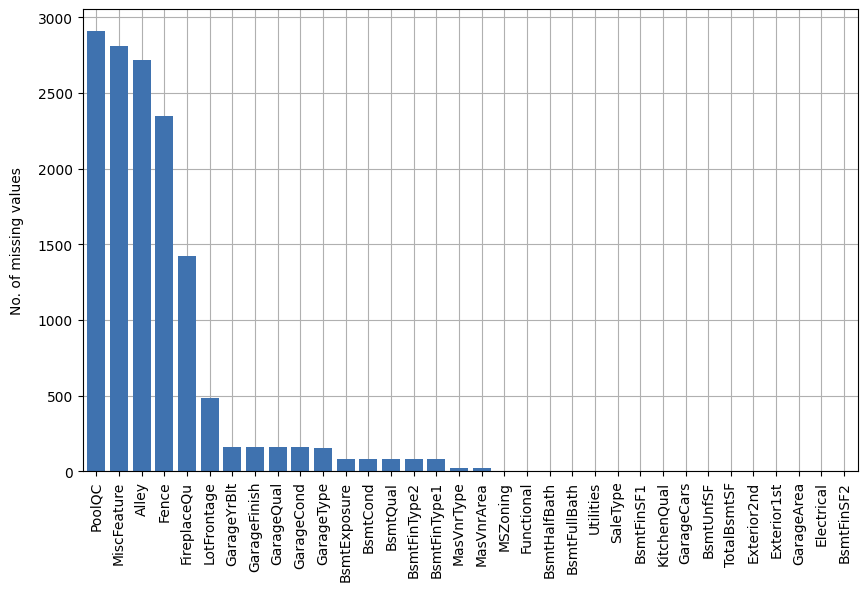

In [87]:
# plot number of missing values in columns with at least one missing variable
nans = X.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.bar(nans.index, nans.values, zorder=2, color="#3f72af")
ax.set_ylabel("No. of missing values", labelpad=10)
ax.set_xlim(-0.6, len(nans) - 0.4)
ax.xaxis.set_tick_params(rotation=90)
plt.show()

In [88]:
# missing zero values table
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

missing_zero_values_table(X)

Your selected dataframe has 79 columns and 2917 Rows.
There are 34 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
PoolQC,0,2908,99.7,2908,99.7,object
MiscFeature,0,2812,96.4,2812,96.4,object
Alley,0,2719,93.2,2719,93.2,object
Fence,0,2346,80.4,2346,80.4,object
FireplaceQu,0,1420,48.7,1420,48.7,object
LotFrontage,0,486,16.7,486,16.7,float64
GarageFinish,0,159,5.5,159,5.5,object
GarageQual,0,159,5.5,159,5.5,object
GarageCond,0,159,5.5,159,5.5,object
GarageYrBlt,0,159,5.5,159,5.5,float64


In [ ]:
cols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageCond", "GarageQual", "GarageFinish", "GarageType", ""]

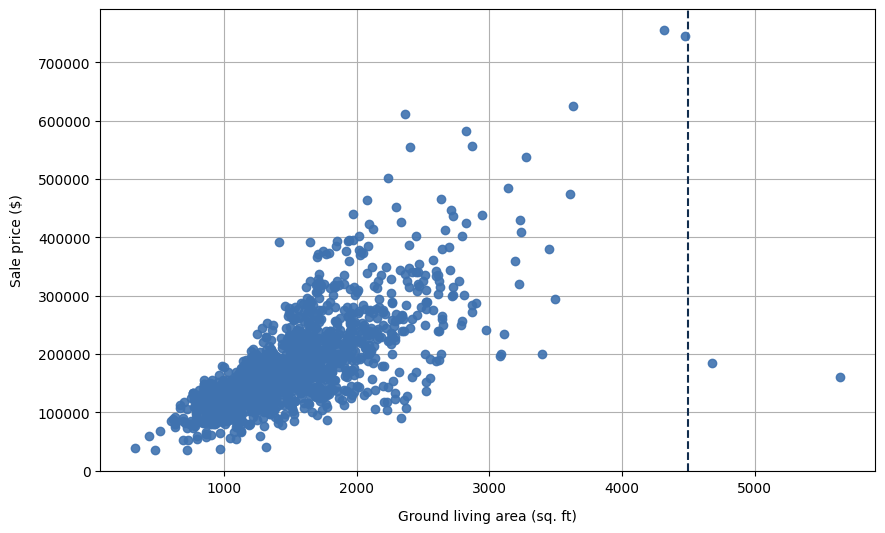

In [72]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.scatter(df_train["GrLivArea"], df_train["SalePrice"], c="#3f72af", zorder=3, alpha=0.9)
ax.axvline(4500, c="#112d4e", ls="--", zorder=2)
ax.set_xlabel("Ground living area (sq. ft)", labelpad=10)
ax.set_ylabel("Sale price ($)", labelpad=10)
plt.show()

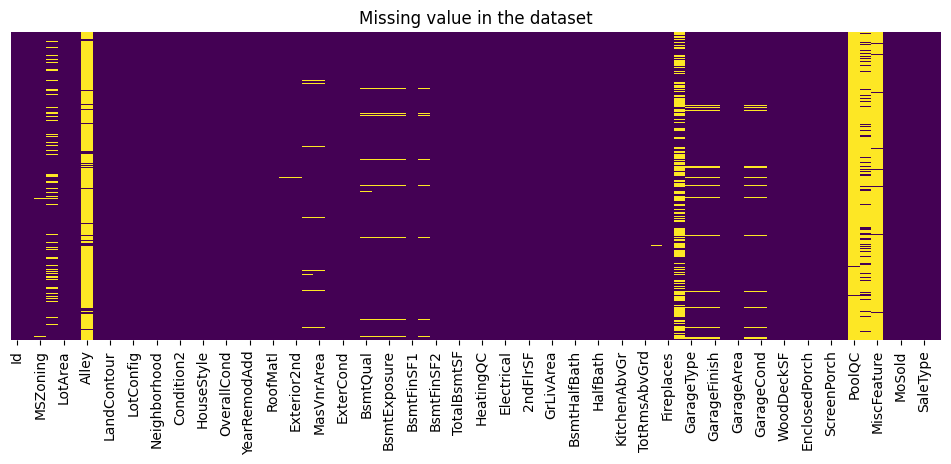

In [34]:
plt.figure(figsize=(12,4))
sn.heatmap(df_train.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

Your selected dataframe has 80 columns and 1459 Rows.
There are 33 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
PoolQC,0,1456,99.8,1456,99.8,object
MiscFeature,0,1408,96.5,1408,96.5,object
Alley,0,1352,92.7,1352,92.7,object
Fence,0,1169,80.1,1169,80.1,object
FireplaceQu,0,730,50.0,730,50.0,object
LotFrontage,0,227,15.6,227,15.6,float64
GarageCond,0,78,5.3,78,5.3,object
GarageYrBlt,0,78,5.3,78,5.3,float64
GarageQual,0,78,5.3,78,5.3,object
GarageFinish,0,78,5.3,78,5.3,object


In [39]:
df_train.drop(columns=['Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
print(df_train.isnull().sum())
print(df_train.shape)

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 75, dtype: int64
(1459, 75)


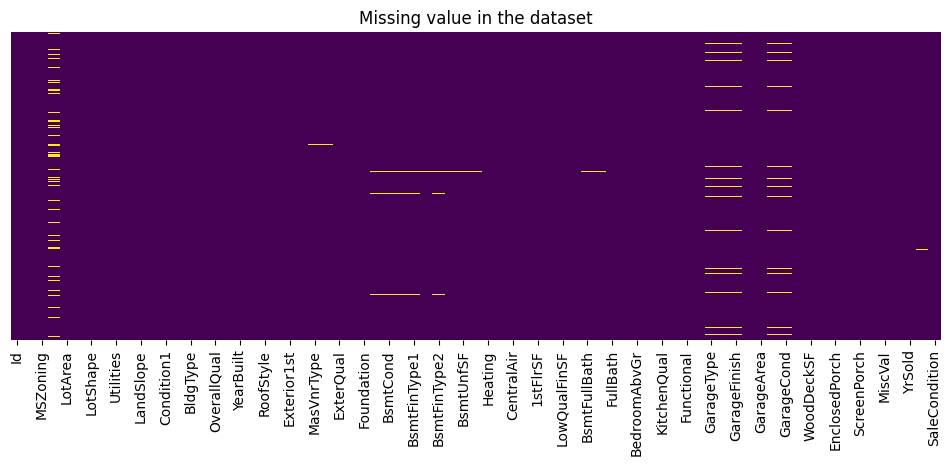

In [40]:
plt.figure(figsize=(12,4))
sn.heatmap(df_train.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

In [41]:
missing_zero_values_table(df_train)

Your selected dataframe has 75 columns and 1459 Rows.
There are 28 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
LotFrontage,0,227,15.6,227,15.6,float64
GarageYrBlt,0,78,5.3,78,5.3,float64
GarageCond,0,78,5.3,78,5.3,object
GarageQual,0,78,5.3,78,5.3,object
GarageFinish,0,78,5.3,78,5.3,object
GarageType,0,76,5.2,76,5.2,object
BsmtCond,0,45,3.1,45,3.1,object
BsmtQual,0,44,3.0,44,3.0,object
BsmtExposure,0,44,3.0,44,3.0,object
BsmtFinType1,0,42,2.9,42,2.9,object


In [13]:
# Correlation matrix

f,ax = plt.subplots(figsize=(200,100))
corr = df.corr()
plt.figure(figsize=(200,100))
sn.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sn.diverging_palette(220,10,as_cmap=True),
          square=True,ax=ax,annot=True)


NameError: ignored